In [12]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import numpy as np
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, distance
from scipy.optimize import linear_sum_assignment
import networkx as nx
import pandas as pd
import random
import logging

from data.dataloader import DataLoader


In [13]:

# Configurar logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] %(levelname)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.info(f'Logging level: {logging.getLevelName(logger.getEffectiveLevel())}')


[2025-02-21 20:06:47] INFO: Logging level: INFO


In [14]:

def load_and_preprocess_images(img_path1, img_path2, mat_path1, mat_path2, target_size=(256,256)):
    """
    Carga y redimensiona dos imágenes junto a sus keypoints.
    """
    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)
    mat_data1 = sio.loadmat(mat_path1)
    mat_data2 = sio.loadmat(mat_path2)
    kpts1 = np.array(mat_data1['pts_coord'])
    kpts2 = np.array(mat_data2['pts_coord'])
    
    # Ajustar los keypoints al nuevo tamaño
    orig_size1 = img1.size
    orig_size2 = img2.size
    kpts1[0] = kpts1[0] * target_size[0] / orig_size1[0]
    kpts1[1] = kpts1[1] * target_size[1] / orig_size1[1]
    kpts2[0] = kpts2[0] * target_size[0] / orig_size2[0]
    kpts2[1] = kpts2[1] * target_size[1] / orig_size2[1]
    
    img1 = img1.resize(target_size, resample=Image.BILINEAR)
    img2 = img2.resize(target_size, resample=Image.BILINEAR)
    
    return img1, img2, kpts1, kpts2

def delaunay_triangulation(kpts):
    """
    Construye la matriz de adyacencia basándose en la triangulación de Delaunay.
    """
    pts = kpts.T
    tri = Delaunay(pts)
    N = pts.shape[0]
    A = np.zeros((N, N))
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                A[simplex[i], simplex[j]] = 1
                A[simplex[j], simplex[i]] = 1
    return A

def compute_node2vec_embeddings(G, dimensions=64, num_walks=10, walk_length=30):
    """
    Función placeholder para calcular embeddings con node2vec.
    Se debe reemplazar con una implementación real.
    """
    n = G.number_of_nodes()
    embeddings = np.random.rand(n, dimensions)
    return embeddings

def hitting_time(G, start_node, destination_node, num_walks=100):
    """
    Aproxima el hitting time entre dos nodos mediante caminatas aleatorias.
    """
    hits = []
    for _ in range(num_walks):
        current = start_node
        steps = 0
        while current != destination_node and steps < 1000:
            neighbors = list(G.neighbors(current))
            if not neighbors:
                break
            current = random.choice(neighbors)
            steps += 1
        hits.append(steps)
    return np.mean(hits)

def compute_hitting_time_matrix(G):
    """
    Computa la matriz de hitting times para todos los pares de nodos.
    """
    n = G.number_of_nodes()
    hitting_times = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            h_time = hitting_time(G, i, j)
            hitting_times[i, j] = h_time
            hitting_times[j, i] = h_time
    return hitting_times

def enhanced_spatial_matching(kpts1, kpts2, adj_matrix1, adj_matrix2):
    """
    Realiza matching utilizando características espaciales junto a embeddings (node2vec y hitting times).
    Se construye una matriz de coste combinada y se aplica el algoritmo húngaro.
    
    Se ha modificado la parte de hitting times: en vez de restar las filas completas (que pueden tener longitudes diferentes), 
    se calcula para cada nodo el valor medio de su hitting profile y se compara esos valores.
    """
    n1 = kpts1.shape[1]
    n2 = kpts2.shape[1]
    
    # Construir grafos con las matrices de adyacencia
    G1 = nx.from_numpy_array(adj_matrix1)
    G2 = nx.from_numpy_array(adj_matrix2)
    
    node2vec_emb1 = compute_node2vec_embeddings(G1)
    node2vec_emb2 = compute_node2vec_embeddings(G2)
    
    hitting_times1 = compute_hitting_time_matrix(G1)  # Shape: (n1, n1)
    hitting_times2 = compute_hitting_time_matrix(G2)  # Shape: (n2, n2)
    
    cost_matrix = np.zeros((n1, n2))
    for i in range(n1):
        profile1 = np.mean(hitting_times1[i])
        for j in range(n2):
            profile2 = np.mean(hitting_times2[j])
            spatial_dist = np.linalg.norm(kpts1[:, i] - kpts2[:, j])
            node2vec_dist = np.linalg.norm(node2vec_emb1[i] - node2vec_emb2[j])
            hitting_profile_dist = abs(profile1 - profile2)
            cost_matrix[i, j] = 0.4 * spatial_dist + 0.3 * node2vec_dist + 0.3 * hitting_profile_dist
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    matching = np.zeros((n1, n2), dtype=int)
    matching[row_ind, col_ind] = 1
    return matching

def visualize_matching_full(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching):
    """
    Visualiza el matching: concatena ambas imágenes y dibuja líneas entre los keypoints emparejados.
    """
    h1, w1 = np.array(img1).shape[:2]
    h2, w2 = np.array(img2).shape[:2]
    composite_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    composite_img[:h1, :w1, :] = np.array(img1)
    composite_img[:h2, w1:w1+w2, :] = np.array(img2)
    
    kpts2_shifted = kpts2.copy()
    kpts2_shifted[0, :] += w1
    
    plt.figure(figsize=(10, 10))
    plt.imshow(composite_img)
    
    for (kpts, adj_matrix, color) in [(kpts1, adj_matrix1, 'r'), (kpts2_shifted, adj_matrix2, 'b')]:
        N = kpts.shape[1]
        for i in range(N):
            for j in range(i+1, N):
                if adj_matrix[i, j]:
                    plt.plot([kpts[0, i], kpts[0, j]], [kpts[1, i], kpts[1, j]], color+'-', linewidth=1)
        plt.scatter(kpts[0], kpts[1], c=color, edgecolors='w', s=80)
    
    row_ind, col_ind = np.where(matching == 1)
    for r, c in zip(row_ind, col_ind):
        x1, y1 = kpts1[:, r]
        x2, y2 = kpts2_shifted[:, c]
        if r == c:
            plt.plot([x1, x2], [y1, y2], 'g-', linewidth=1)
        else:
            plt.plot([x1, x2], [y1, y2], 'r-', linewidth=1)
    
    plt.title("Matching Avanzado: Embeddings + Delaunay")
    plt.axis('off')
    plt.show()

def evaluate_matching_precision(kpts, matching):
    """
    Asume que la correspondencia ideal es la diagonal de la matriz de matching.
    """
    N = kpts.shape[1]
    row_ind, col_ind = np.where(matching == 1)
    correct = np.sum(row_ind == col_ind)
    return correct / N if N != 0 else 0

def compute_precision_for_all_categories():
    """
    Para cada categoría:
    1. Selecciona aleatoriamente un par de imágenes y muestra la visualización utilizando el matching avanzado.
    2. Recorre pares consecutivos para calcular la precisión (se asume que la correspondencia ideal es la diagonal).
    3. Acumula los resultados en results2.csv con las columnas:
       Category,Mean_Accuracy,Std_Deviation,Number_of_Images
    """
    dl = DataLoader()
    dataframes = dl.load_data()
    
    overall_results = []  # Acumula los resultados globales

    for cat_name, cat_df in dataframes.items():
        if len(cat_df) < 2:
            logger.info(f"No hay suficientes imágenes en {cat_name}")
            continue
        
        # --- Visualización de un par aleatorio para la categoría ---
        sample = cat_df.sample(2)
        row1 = sample.iloc[0]
        row2 = sample.iloc[1]
        img_path1, mat_path1 = row1['img'], row1['mat']
        img_path2, mat_path2 = row2['img'], row2['mat']
        
        # Cargar y preprocesar imágenes y sus keypoints (manteniendo el escalado de la práctica2)
        img1, img2, kpts1, kpts2 = load_and_preprocess_images(img_path1, img_path2, mat_path1, mat_path2)
        adj1 = delaunay_triangulation(kpts1)
        adj2 = delaunay_triangulation(kpts2)
        
        matching = enhanced_spatial_matching(kpts1, kpts2, adj1, adj2)
        logger.info(f"Visualizando par aleatorio para {cat_name}")
        visualize_matching_full(img1, img2, kpts1, kpts2, adj1, adj2, matching)
        
        # --- Cálculo de la precisión para pares consecutivos ---
        precisions = []
        for i in range(len(cat_df) - 1):
            row_a = cat_df.iloc[i]
            row_b = cat_df.iloc[i+1]
            # Cargar la imagen y keypoints de cada par
            img_a, img_b, kpts_a, kpts_b = load_and_preprocess_images(row_a['img'], row_b['img'], row_a['mat'], row_b['mat'])
            A_a = delaunay_triangulation(kpts_a)
            A_b = delaunay_triangulation(kpts_b)
            
            matching_pair = enhanced_spatial_matching(kpts_a, kpts_b, A_a, A_b)
            prec = evaluate_matching_precision(kpts_a, matching_pair)
            precisions.append(prec)
        
        media = np.mean(precisions)
        std = np.std(precisions)
        
        # Aquí se integran los logs solicitados:
        logger.info(f"Categoría {cat_name.capitalize()}: Precisión media = {media:.4f}, Desviación = {std:.4f}")
        logger.info(f"Resultados procesados para {cat_name} con {len(cat_df)} imágenes")
        
        overall_results.append({
            "Category": cat_name,
            "Mean_Accuracy": round(media, 4),
            "Std_Deviation": round(std, 4),
            "Number_of_Images": len(cat_df)
        })
    
    # Guardar un CSV global con los datos de todas las categorías
    results_df = pd.DataFrame(overall_results)
    results_df.to_csv("results2.csv", index=False)
    logger.info("Resultados globales guardados en results2.csv")



[2025-02-21 20:07:33] INFO: Visualizando par aleatorio para car_df


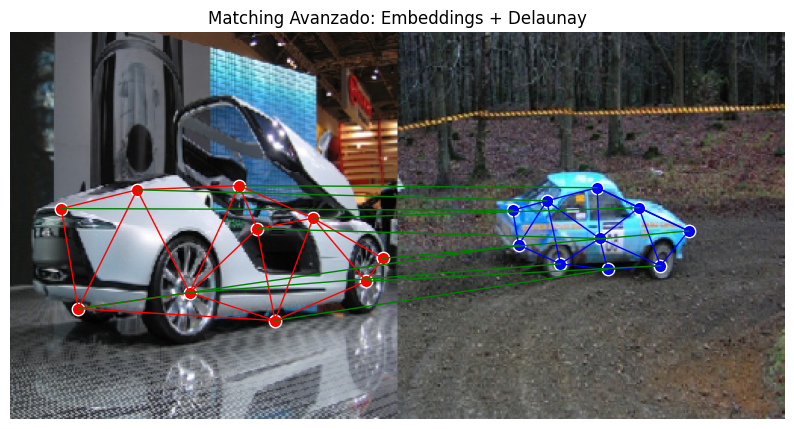

[2025-02-21 20:07:37] INFO: Categoría Car_df: Precisión media = 0.7974, Desviación = 0.2703
[2025-02-21 20:07:37] INFO: Resultados procesados para car_df con 40 imágenes
[2025-02-21 20:07:37] INFO: Visualizando par aleatorio para face_df


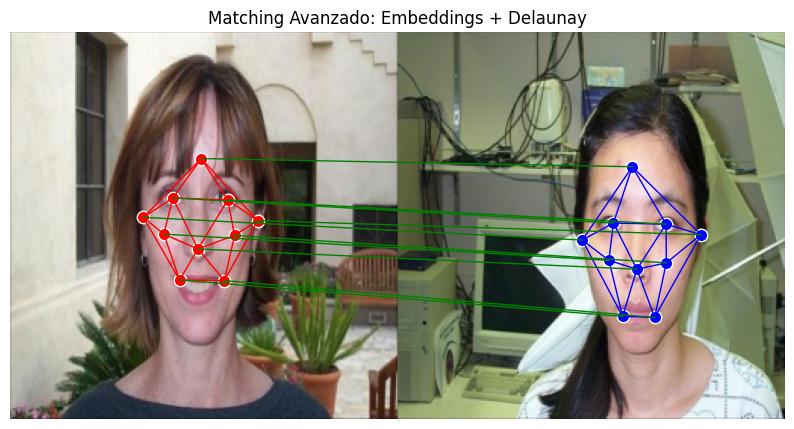

[2025-02-21 20:07:48] INFO: Categoría Face_df: Precisión media = 0.9187, Desviación = 0.1468
[2025-02-21 20:07:48] INFO: Resultados procesados para face_df con 109 imágenes
[2025-02-21 20:07:48] INFO: Visualizando par aleatorio para duck_df


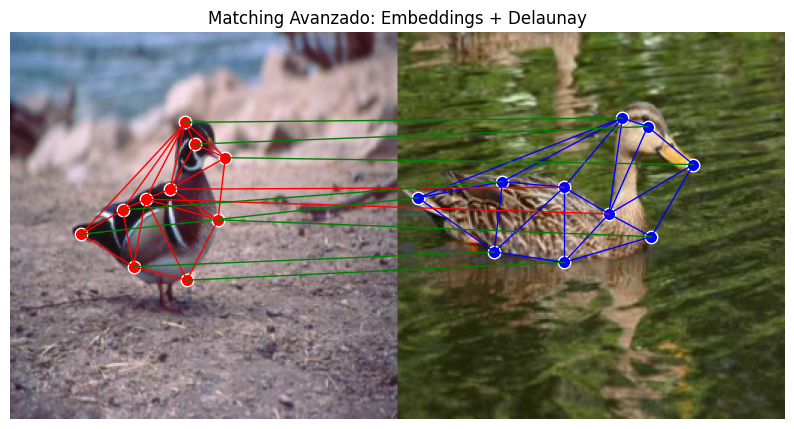

[2025-02-21 20:07:54] INFO: Categoría Duck_df: Precisión media = 0.8020, Desviación = 0.3061
[2025-02-21 20:07:54] INFO: Resultados procesados para duck_df con 50 imágenes
[2025-02-21 20:07:54] INFO: Visualizando par aleatorio para motorbike_df


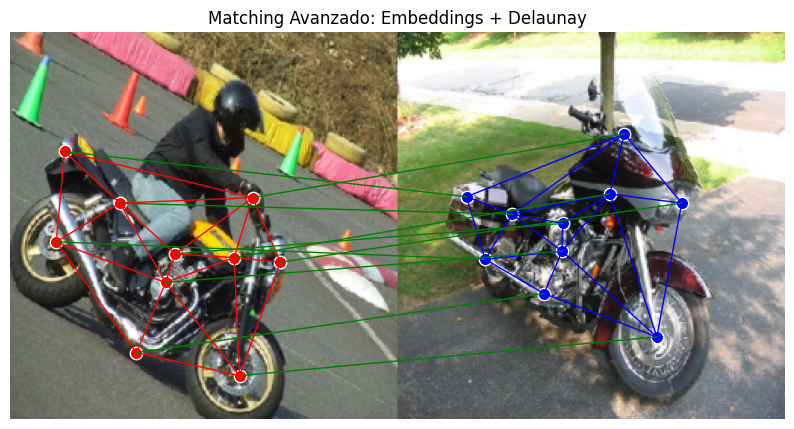

[2025-02-21 20:07:59] INFO: Categoría Motorbike_df: Precisión media = 0.8692, Desviación = 0.2244
[2025-02-21 20:07:59] INFO: Resultados procesados para motorbike_df con 40 imágenes
[2025-02-21 20:07:59] INFO: No hay suficientes imágenes en __pycache___df
[2025-02-21 20:07:59] INFO: Visualizando par aleatorio para winebottle_df


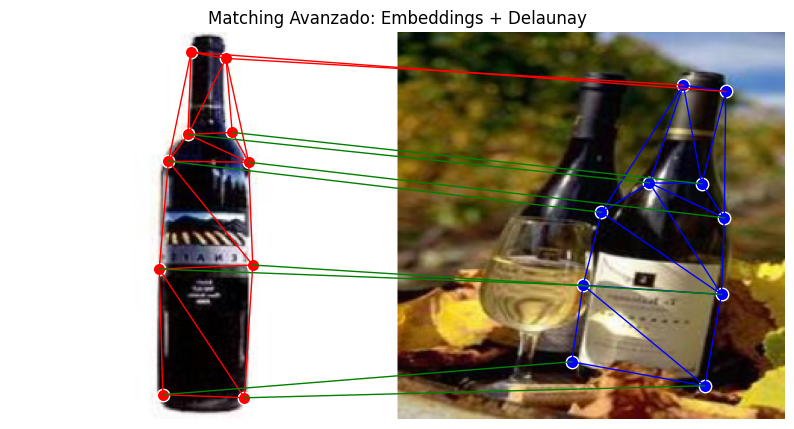

[2025-02-21 20:08:07] INFO: Categoría Winebottle_df: Precisión media = 0.8723, Desviación = 0.2130
[2025-02-21 20:08:07] INFO: Resultados procesados para winebottle_df con 66 imágenes
[2025-02-21 20:08:07] INFO: Resultados globales guardados en results2.csv


In [15]:

if __name__ == "__main__":
    compute_precision_for_all_categories()

## RESULTADOS FINALES

In [16]:
resultados = pd.read_csv("results2.csv")
resultados

,Category,Mean_Accuracy,Std_Deviation,Number_of_Images
0,car_df,0.7974,0.2703,40
1,face_df,0.9188,0.1468,109
2,duck_df,0.8020,0.3061,50
3,motorbike_df,0.8692,0.2244,40
4,winebottle_df,0.8723,0.2130,66
